# Data Analysis

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mcap.reader import make_reader
from mcap_protobuf.decoder import DecoderFactory
import toml


def extract_numeric_fields(proto):
    fields = sorted(proto.DESCRIPTOR.fields, key=lambda f: f.number)
    values = []
    for f in fields:
        if f.type in (f.TYPE_FLOAT, f.TYPE_DOUBLE):
            try:
                values.append(float(getattr(proto, f.name)))
            except Exception:
                pass
    return values

{'wheel_base': 1.12, 'front_track_width': 1.03, 'rear_track_width': 0.8, 'front_wheel_diameter': 0.5334, 'rear_wheel_diameter': 0.5334, 'frontcam_position': [1.2, 0.0375, 1.05], 'frontcam_rotation': [0.430459334576879, -0.560985526796931, 0.560985526796931, -0.430459334576879], 'imu_position': [1.2, 0.0375, 1.05], 'imu_rotation': [-0.608761429008721, 0.0, -0.793353340291235, 0.0]}


In [ ]:
with open("data.toml", "r") as f:
    data = toml.load(f)

print(data)

In [7]:

def load_data(mcap_path):
    imu_data, cmd_data, fb_data, gt_data = [], [], [], []

    with open(mcap_path, "rb") as f:
        reader = make_reader(f, decoder_factories=[DecoderFactory()])
        for _, channel, message, proto in reader.iter_decoded_messages():
            ts = message.log_time / 1e9
            t = channel.topic

            if t == "oakd/front/imu":
                imu_data.append([
                    ts,
                    proto.linear_acceleration.x,
                    proto.linear_acceleration.y,
                    proto.linear_acceleration.z,
                    proto.angular_velocity.x,
                    proto.angular_velocity.y,
                    proto.angular_velocity.z,
                ])

            elif t == "drive_cmd":
                nums = extract_numeric_fields(proto)
                theta_cmd, omega_cmd = (nums + [0.0, 0.0])[:2]
                cmd_data.append([ts, theta_cmd, omega_cmd])

            elif t == "drive_feedback":
                nums = extract_numeric_fields(proto)
                theta_fb, omega_fb = (nums + [0.0, 0.0])[:2]
                fb_data.append([ts, theta_fb, omega_fb])

            elif t == "robot_pose/ground_truth":
                gt_data.append([
                    ts,
                    float(proto.x),
                    float(proto.y),
                    float(getattr(proto, 'yaw', 0.0)),
                ])

    columns = {
        "imu": ["time","ax","ay","az","gx","gy","gz"],
        "cmd": ["time","theta_cmd","omega_cmd"],
        "fb":  ["time","theta_fb","omega_fb"],
        "gt":  ["time","x","y","yaw"],
    }

    imu_df = pd.DataFrame(imu_data, columns=columns["imu"])
    cmd_df = pd.DataFrame(cmd_data, columns=columns["cmd"])
    fb_df  = pd.DataFrame(fb_data, columns=columns["fb"])
    gt_df  = pd.DataFrame(gt_data, columns=columns["gt"])

    for df in (imu_df, cmd_df, fb_df, gt_df):
        if not df.empty:
            df.sort_values("time", inplace=True)
            df.set_index("time", inplace=True)

    return imu_df, cmd_df, fb_df, gt_df

# Load once and reuse
mcap_path = "data.mcap"
imu_df, cmd_df, fb_df, gt_df = load_data(mcap_path)


In [8]:
print("=== IMU ==="); print(imu_df.describe() if not imu_df.empty else "no data")
print("\n=== CMD ==="); print(cmd_df.describe() if not cmd_df.empty else "no data")
print("\n=== FB ===");  print(fb_df.describe()  if not fb_df.empty else "no data")
print("\n=== GT ===");  print(gt_df.describe()  if not gt_df.empty else "no data")


=== IMU ===
                ax           ay           az           gx           gy  \
count  6356.000000  6356.000000  6356.000000  6356.000000  6356.000000   
mean     -9.598393     0.110856    -2.899516    -0.031691    -0.000523   
std       5.681420     5.046128     5.454243     0.336412     0.033498   
min     -28.780714   -19.274187   -23.328962    -0.630135    -0.124408   
25%     -12.590402    -1.180192    -4.738811    -0.369612    -0.023045   
50%      -9.554598     0.021185    -2.530790    -0.008275    -0.000913   
75%      -8.470111     1.961743    -0.999054     0.179776     0.022271   
max       7.805346    19.955533    13.684332     0.628324     0.118307   

                gz  
count  6356.000000  
mean     -0.008273  
std       0.095167  
min      -0.238895  
25%      -0.086256  
50%      -0.005309  
75%       0.057632  
max       0.244081  

=== CMD ===
         theta_cmd    omega_cmd
count  1952.000000  1952.000000
mean      0.055507     5.710936
std       0.202884     

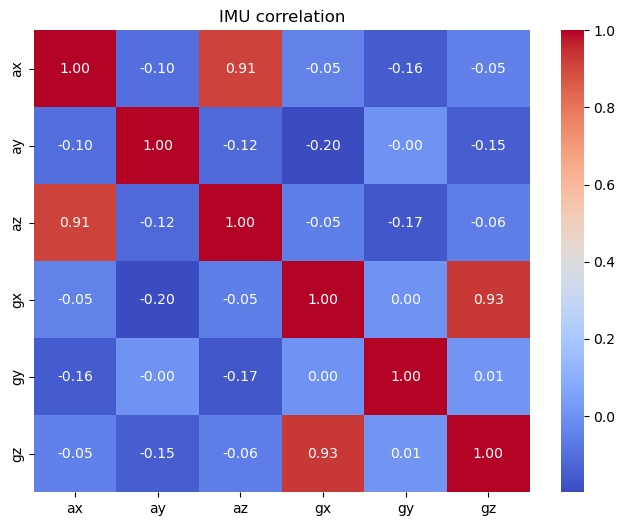

In [9]:
if not imu_df.empty:
    plt.figure(figsize=(8,6))
    sns.heatmap(imu_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("IMU correlation")
    plt.show()


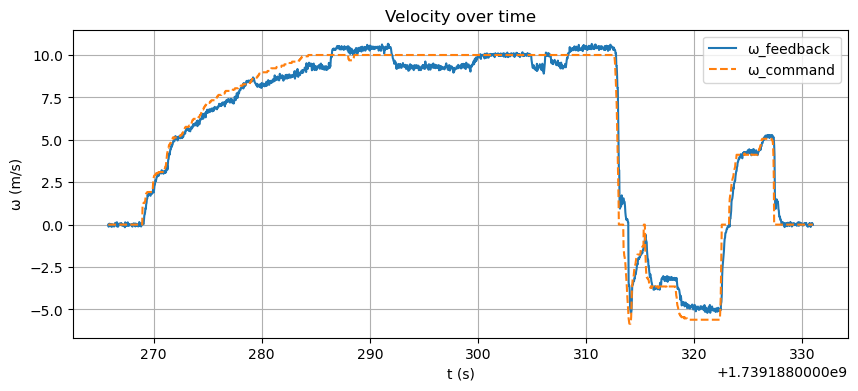

In [10]:
if not fb_df.empty and not cmd_df.empty:
    t_fb  = fb_df.index.values
    w_fb  = fb_df["omega_fb"].values
    t_cmd = cmd_df.index.values
    w_cmd = cmd_df["omega_cmd"].values

    plt.figure(figsize=(10,4))
    plt.plot(t_fb,  w_fb,  label="ω_feedback")
    plt.plot(t_cmd, w_cmd, "--", label="ω_command")
    plt.title("Velocity over time")
    plt.xlabel("t (s)")
    plt.ylabel("ω (m/s)")
    plt.legend()
    plt.grid(True)
    plt.show()


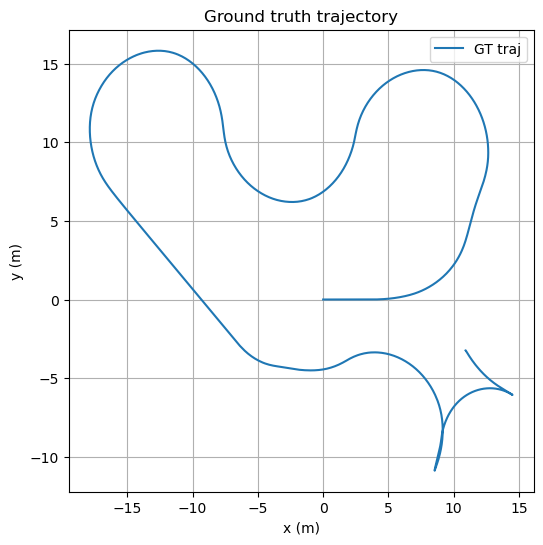

In [11]:
if not gt_df.empty:
    x = gt_df["x"].values
    y = gt_df["y"].values

    plt.figure(figsize=(6,6))
    plt.plot(x, y, label="GT traj")
    plt.title("Ground truth trajectory")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.legend()
    plt.grid(True)
    plt.show()


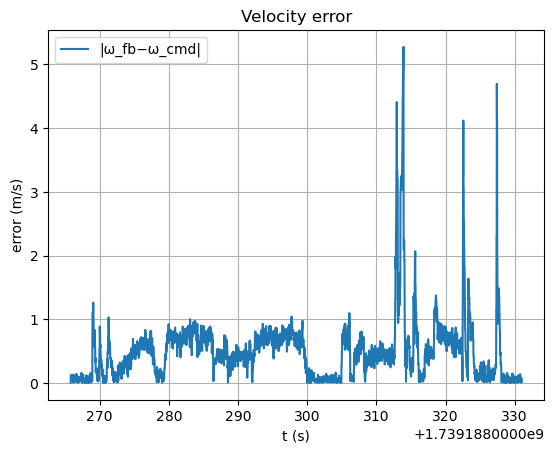

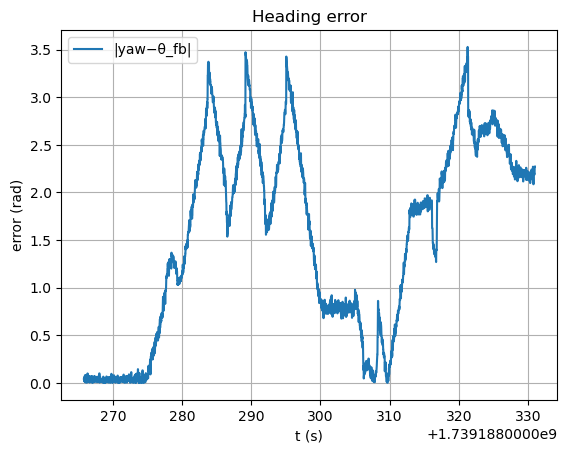

In [12]:
if not gt_df.empty and not fb_df.empty:
    # merge as before, then:
    merged = pd.merge_asof(
        gt_df, fb_df, left_index=True, right_index=True,
        direction="nearest", tolerance=0.1
    )
    if not cmd_df.empty:
        merged = pd.merge_asof(
            merged.reset_index(), cmd_df.reset_index(),
            on="time", direction="nearest", tolerance=0.1
        ).set_index("time")

    t_m = merged.index.values

    # Velocity error
    if "omega_cmd" in merged:
        vel_err = np.abs(merged["omega_fb"].values - merged["omega_cmd"].values)
        plt.figure()
        plt.plot(t_m, vel_err, label="|ω_fb−ω_cmd|")
        plt.title("Velocity error")
        plt.xlabel("t (s)")
        plt.ylabel("error (m/s)")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Heading error
    if "theta_fb" in merged:
        hdg_err = np.abs(merged["yaw"].values - merged["theta_fb"].values)
        plt.figure()
        plt.plot(t_m, hdg_err, label="|yaw−θ_fb|")
        plt.title("Heading error")
        plt.xlabel("t (s)")
        plt.ylabel("error (rad)")
        plt.legend()
        plt.grid(True)
        plt.show()


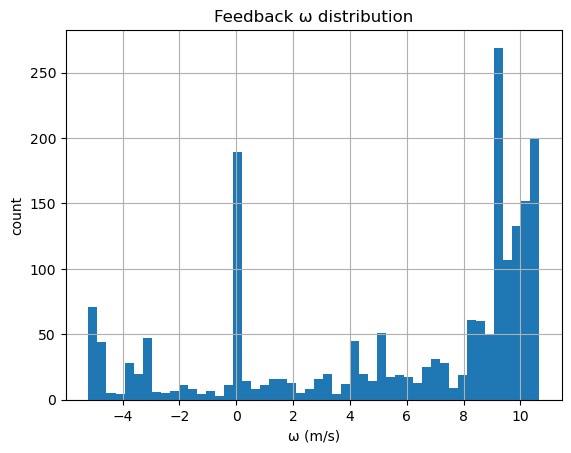

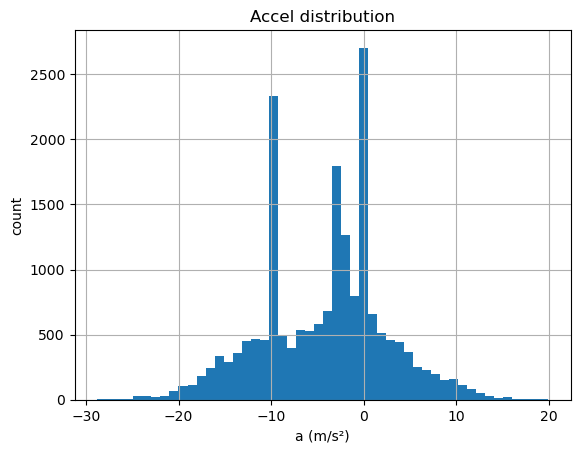

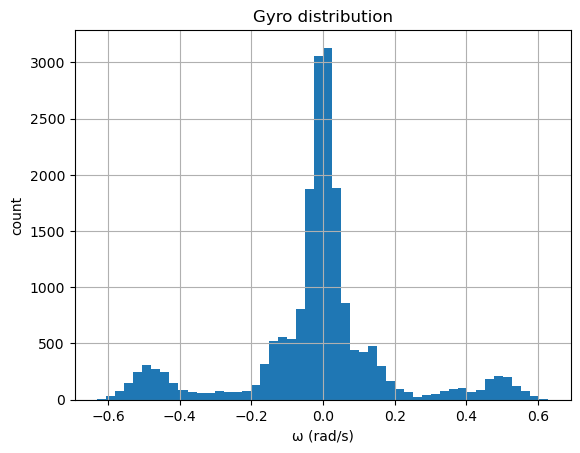

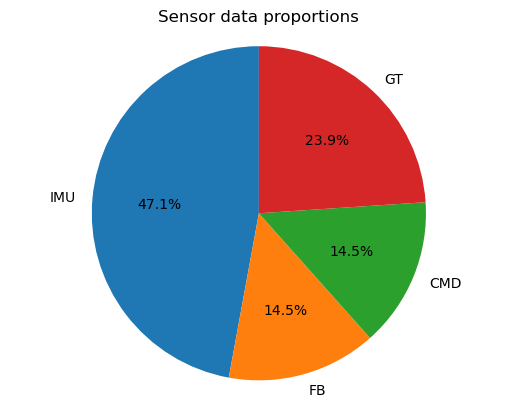

In [13]:
# Feedback ω histogram
if not fb_df.empty:
    data_fb = fb_df["omega_fb"].values
    plt.figure()
    plt.hist(data_fb, bins=50)
    plt.title("Feedback ω distribution")
    plt.xlabel("ω (m/s)")
    plt.ylabel("count")
    plt.grid(True)
    plt.show()

# Accel & Gyro distributions
if not imu_df.empty:
    acc = imu_df[["ax","ay","az"]].values.flatten()
    gyro= imu_df[["gx","gy","gz"]].values.flatten()

    # Accel
    plt.figure()
    plt.hist(acc, bins=50)
    plt.title("Accel distribution")
    plt.xlabel("a (m/s²)")
    plt.ylabel("count")
    plt.grid(True)
    plt.show()

    # Gyro
    plt.figure()
    plt.hist(gyro, bins=50)
    plt.title("Gyro distribution")
    plt.xlabel("ω (rad/s)")
    plt.ylabel("count")
    plt.grid(True)
    plt.show()

# Pie chart of data proportions
counts = {
    "IMU": len(imu_df),
    "FB":  len(fb_df),
    "CMD": len(cmd_df),
    "GT":  len(gt_df),
}
plt.figure()
plt.pie(list(counts.values()), labels=list(counts.keys()),
        autopct="%1.1f%%", startangle=90)
plt.title("Sensor data proportions")
plt.axis("equal")
plt.show()


# EKF Model For State Prediction 


In [14]:
# Cell 1: Imports & Parameters
import toml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mcap.reader import make_reader
from mcap_protobuf.decoder import DecoderFactory
from google.protobuf.descriptor import FieldDescriptor

# Load robot geometry
params = toml.load("data.toml")
WHEEL_BASE = params.get("wheel_base", params.get("wheelbase", 1.0))


In [15]:
# Cell 2: Protobuf helper
def extract_numeric_fields(proto):
    """
    Return all float/double (non-repeated) fields from a protobuf message as a list.
    """
    values = []
    for f in sorted(proto.DESCRIPTOR.fields, key=lambda f: f.number):
        if f.type in (FieldDescriptor.TYPE_FLOAT, FieldDescriptor.TYPE_DOUBLE) \
           and f.label != FieldDescriptor.LABEL_REPEATED:
            v = getattr(proto, f.name)
            if isinstance(v, (float, int)):
                values.append(float(v))
    return values


In [16]:
# Cell 3: Load & synchronize data
def load_and_sync(mcap_path, tol=0.02):
    """
    Reads data.mcap and returns a single DataFrame with columns:
      time, gz, theta_fb, omega_fb, theta_cmd, omega_cmd, x_gt, y_gt, yaw_gt
    Merging is done with nearest timestamp within `tol` seconds.
    """
    imu, fb, cmd, gt = [], [], [], []
    with open(mcap_path, "rb") as f:
        reader = make_reader(f, decoder_factories=[DecoderFactory()])
        for _, ch, msg, p in reader.iter_decoded_messages():
            t = msg.log_time / 1e9
            topic = ch.topic
            if topic == "oakd/front/imu":
                imu.append([t, p.angular_velocity.z])
            elif topic == "drive_feedback":
                θf, ωf = (extract_numeric_fields(p) + [0,0])[:2]
                fb.append([t, θf, ωf])
            elif topic == "drive_cmd":
                θc, ωc = (extract_numeric_fields(p) + [0,0])[:2]
                cmd.append([t, θc, ωc])
            elif topic == "robot_pose/ground_truth":
                yaw = getattr(p, "yaw", 0.0)
                gt.append([t, p.x, p.y, yaw])

    def mkdf(data, cols):
        df = pd.DataFrame(data, columns=cols)
        if df.empty: return df
        return df.sort_values("time").set_index("time")

    imu_df = mkdf(imu, ["time","gz"])
    fb_df  = mkdf(fb,  ["time","theta_fb","omega_fb"])
    cmd_df = mkdf(cmd, ["time","theta_cmd","omega_cmd"])
    gt_df  = mkdf(gt,  ["time","x_gt","y_gt","yaw_gt"])

    m = pd.merge_asof(gt_df.reset_index(), imu_df.reset_index(),
                      on="time", direction="nearest", tolerance=tol)
    m = pd.merge_asof(m, fb_df.reset_index(),
                      on="time", direction="nearest", tolerance=tol)
    m = pd.merge_asof(m, cmd_df.reset_index(),
                      on="time", direction="nearest", tolerance=tol)
    return m.dropna()

data = load_and_sync("data.mcap")


In [17]:
# Cell 4: EKF class definition
class ExtendedKalmanFilter:
    def __init__(self, x0, P0, Q, R, wheel_base):
        self.x = x0.copy()
        self.P = P0.copy()
        self.Q = Q.copy()
        self.R = R.copy()
        self.L = wheel_base

    def predict(self, u, dt):
        θ, v = u
        x, y, ψ, _ = self.x

        # bicycle kinematic
        x += v * np.cos(ψ) * dt
        y += v * np.sin(ψ) * dt
        ψ += (v / self.L) * np.tan(θ) * dt

        self.x = np.array([x, y, ψ, v])

        # Jacobian F
        F = np.eye(4)
        F[0,2] = -v * np.sin(ψ) * dt
        F[0,3] =  np.cos(ψ) * dt
        F[1,2] =  v * np.cos(ψ) * dt
        F[1,3] =  np.sin(ψ) * dt
        F[2,3] = (1.0 / self.L) * np.tan(θ) * dt

        self.P = F @ self.P @ F.T + self.Q

    def update(self, z, u):
        θ, _ = u
        _, _, ψ, v = self.x

        # Measurement: [gyro_z, velocity]
        H = np.zeros((2,4))
        H[0,3] = (1.0/self.L)*np.tan(θ)
        H[1,3] = 1.0

        z_pred = np.array([ (v/self.L)*np.tan(θ), v ])

        S = H @ self.P @ H.T + self.R
        K = self.P @ H.T @ np.linalg.inv(S)

        self.x = self.x + K @ (z - z_pred)
        I = np.eye(4)
        self.P = (I - K @ H) @ self.P


In [18]:
# Cell 5: Build Q, R and run EKF
t       = data["time"].to_numpy()
gz      = data["gz"].to_numpy()
θ_fb    = data["theta_fb"].to_numpy()
ω_fb    = data["omega_fb"].to_numpy()
θ_cmd   = data["theta_cmd"].to_numpy()
ω_cmd   = data["omega_cmd"].to_numpy()
x_gt    = data["x_gt"].to_numpy()
y_gt    = data["y_gt"].to_numpy()
yaw_gt  = data["yaw_gt"].to_numpy()

# Estimate noise covariances
σ_gz   = np.std(gz)
σ_vfb  = np.std(ω_fb - ω_cmd)  # process mismatch
Q = np.diag([0.01,0.01,0.01,σ_vfb**2])
R = np.diag([σ_gz**2, np.std(ω_fb)**2])

# initialize filter
x0 = np.array([ x_gt[0], y_gt[0], yaw_gt[0], ω_fb[0] ])
P0 = np.diag([0.1,0.1,0.1,0.5])
ekf = ExtendedKalmanFilter(x0, P0, Q, R, WHEEL_BASE)

est = np.zeros((len(t),4))
est[0] = x0

for i in range(1,len(t)):
    dt = t[i]-t[i-1]
    u_fb = (θ_fb[i], ω_fb[i])
    z    = np.array([ gz[i], ω_fb[i] ])
    ekf.predict(u_fb, dt)
    ekf.update(z, u_fb)
    est[i] = ekf.x


In [19]:
# Cell 6: Compute & print RMSE
est_xy = est[:,0:2]
gt_xy  = np.vstack([x_gt,y_gt]).T
rmse_x = np.sqrt(np.mean((est_xy[:,0]-gt_xy[:,0])**2))
rmse_y = np.sqrt(np.mean((est_xy[:,1]-gt_xy[:,1])**2))
print(f"RMSE (x, y) = ({rmse_x:.2f} m, {rmse_y:.2f} m)")


RMSE (x, y) = (5.85 m, 7.03 m)


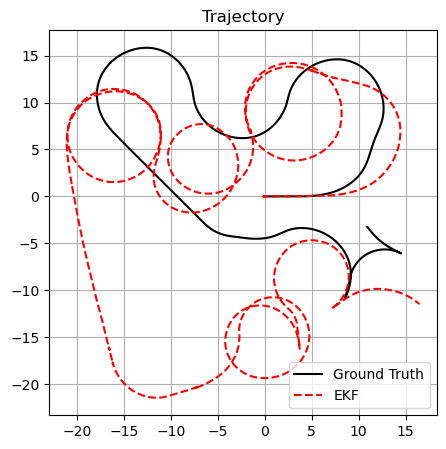

In [20]:
# Trajectory
plt.figure(figsize=(5,5))
plt.plot(gt_xy[:,0],gt_xy[:,1],'k-', label='Ground Truth')
plt.plot(est_xy[:,0],est_xy[:,1],'r--',label='EKF')
plt.axis('equal'); plt.grid(); plt.legend(); plt.title("Trajectory")
plt.show()

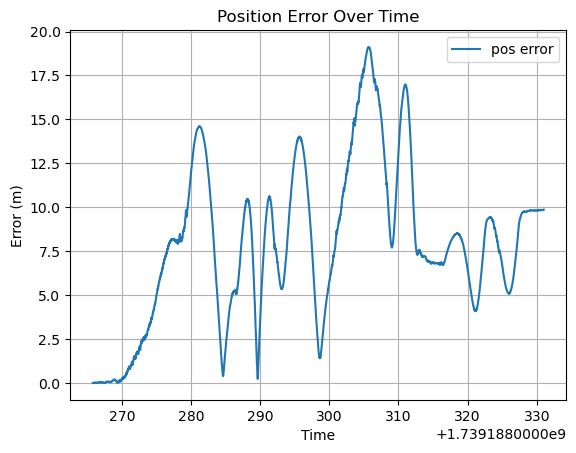

In [21]:
# Position error
err = np.hypot(est_xy[:,0]-gt_xy[:,0], est_xy[:,1]-gt_xy[:,1])
plt.figure()
plt.plot(t, err, label='pos error')
plt.xlabel("Time"); plt.ylabel("Error (m)"); plt.grid(); plt.legend()
plt.title("Position Error Over Time")
plt.show()

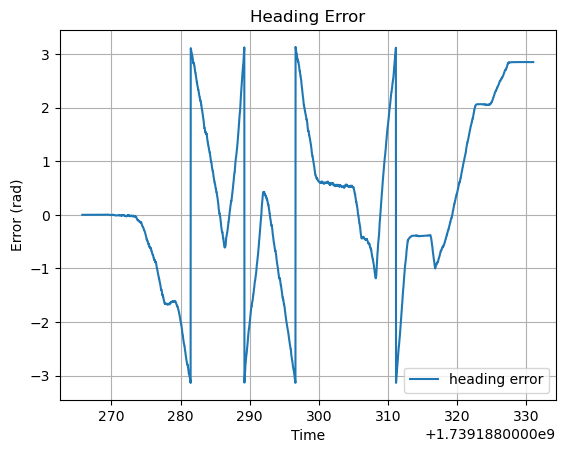

In [22]:
# Heading error
hdg_err = np.arctan2(np.sin(yaw_gt - est[:,2]), np.cos(yaw_gt - est[:,2]))
plt.figure()
plt.plot(t, hdg_err, label='heading error')
plt.xlabel("Time"); plt.ylabel("Error (rad)"); plt.grid(); plt.legend()
plt.title("Heading Error")
plt.show()

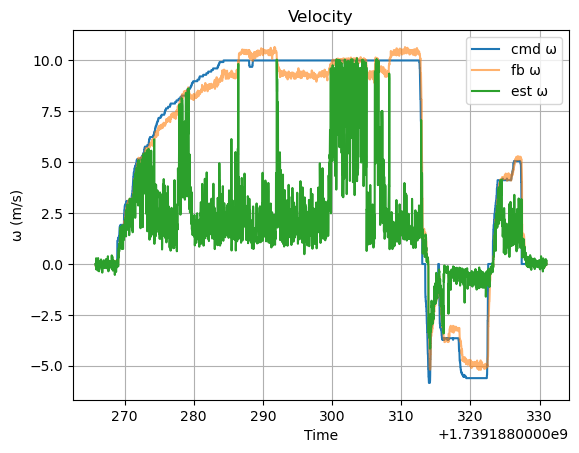

In [23]:
# Velocity comparison
plt.figure()
plt.plot(t, ω_cmd, label='cmd ω')
plt.plot(t, ω_fb,  label='fb ω', alpha=0.6)
plt.plot(t, est[:,3], label='est ω')
plt.xlabel("Time"); plt.ylabel("ω (m/s)"); plt.grid(); plt.legend()
plt.title("Velocity")
plt.show()

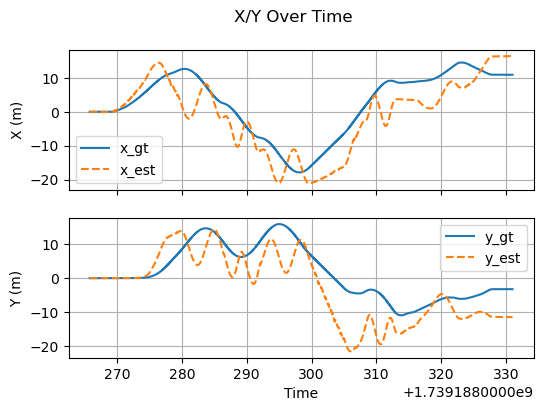

In [24]:
# X & Y over time
fig, ax = plt.subplots(2,1,figsize=(6,4),sharex=True)
ax[0].plot(t, x_gt,  label='x_gt');  ax[0].plot(t, est_xy[:,0],'--',label='x_est')
ax[1].plot(t, y_gt,  label='y_gt');  ax[1].plot(t, est_xy[:,1],'--',label='y_est')
for a in ax: a.grid(); a.legend()
ax[0].set_ylabel("X (m)"); ax[1].set_ylabel("Y (m)"); ax[1].set_xlabel("Time")
plt.suptitle("X/Y Over Time"); plt.show()